In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from bliss.datasets import sdss
from bliss.models import encoder, decoder
from bliss import sleep

In [2]:
import sys
sys.path.insert(0, '../sdss_galaxies/')
from sparse_field_lib import load_data

In [3]:
sys.path.insert(0, './')
import galaxy_simulator_lib
import dataset_lib

In [4]:
sdss_dir = '/home/runingli/astronomy/celeste/data/sdss/'
psf_file = sdss_dir + '/94/1/12/psField-000094-1-0012.fits'

catalog_file = '../sdss_galaxies/coadd_field_catalog_runjing_liu.fit'

In [5]:
device = 'cuda:4'

In [6]:
sdss_psf = sdss.SdssPSF(psf_file, [2])

psf = torch.Tensor(sdss_psf.psf_at_points(0, 0., 0.)).unsqueeze(0).to(device)

In [35]:
simulated_dataset = dataset_lib.SimulatedImages(psf, 
                                                n_images = 5, 
                                                slen = 200, 
                                                flux_range = [2000, 2000],
                                                hlr_range = [1, 1])

In [36]:
gals = simulated_dataset._sample_galaxies()

In [37]:
stars = simulated_dataset._sample_stars()[0]

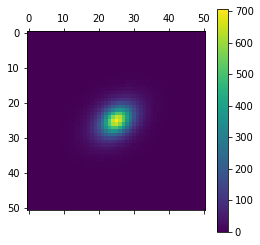

In [38]:
%matplotlib inline
plt.matshow(gals[20, 0].cpu())
plt.colorbar()

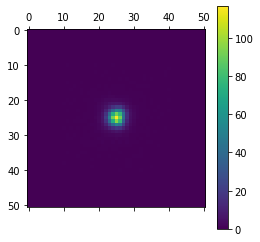

In [39]:
plt.matshow(stars[20, 0].cpu())
plt.colorbar()

In [40]:
image_ptiles, n_sources, locs, fluxes, galaxy_bool = simulated_dataset._sample_ptiles()

In [41]:
image = decoder.ImageDecoder._construct_full_image_from_ptiles(image_ptiles, 
                                                       tile_slen = simulated_dataset.tile_slen, 
                                                       border_padding = 0)
image += simulated_dataset.background

image += torch.randn(image.shape, device = device) * torch.sqrt(image)

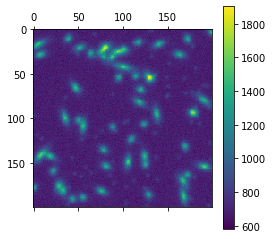

In [42]:
plt.matshow(image[0, 0].cpu())
plt.colorbar()

In [ ]:
n

In [18]:
locs.shape

torch.Size([64, 20, 2, 2])

In [19]:
n_sources

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        ...,
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

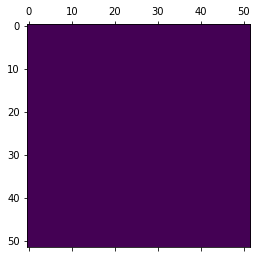

In [21]:
plt.matshow(image_ptiles[0, 0, 0].cpu())

In [12]:
locs = dataset_lib._sample_uniform((0, 1), (simulated_dataset.n_sources, 2))

In [13]:
locs

tensor([[0.4007, 0.8032],
        [0.9220, 0.9798],
        [0.4832, 0.9906],
        ...,
        [0.7629, 0.1044],
        [0.7545, 0.0884],
        [0.9155, 0.1761]], device='cuda:4')

In [17]:
image_ptiles = simulated_dataset.tiler(locs, stars)

image_ptiles = image_ptiles.view(simulated_dataset.batchsize, 
                                 simulated_dataset.n_tiles_per_image, 
                                 1, 
                                 simulated_dataset.ptile_slen, 
                                 simulated_dataset.ptile_slen)

decoder.ImageDecoder._construct_full_image_from_ptiles(image_ptiles, 
                                                       tile_slen = simulated_dataset.tile_slen, 
                                                       border_padding = 0)

RuntimeError: shape '[64, 20, 1, 52, 52]' is invalid for input of size 6922240

In [18]:
image_ptiles.shape

torch.Size([2560, 1, 52, 52])

In [19]:
64 * 20

1280

In [18]:
simulated_dataset.tile_slen

AttributeError: 'SimulatedImages' object has no attribute 'tile_slen'

In [17]:
psf.shape

torch.Size([1, 51, 51])

In [18]:
gals.shape

torch.Size([2560, 1, 51, 51])

In [19]:
gals = gals * 0.
gals[:, :, 25, 25] = 1.

In [30]:
out = dataset_lib._convolve_w_psf(gals, psf)

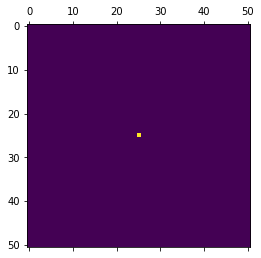

In [31]:
i = np.random.choice(100)

plt.matshow(gals[i, 0].cpu())

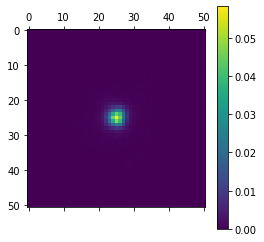

In [32]:
plt.matshow((out[i, 0]).cpu())
plt.colorbar()

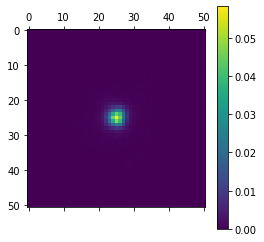

In [33]:
plt.matshow((psf[0]).cpu())
plt.colorbar()

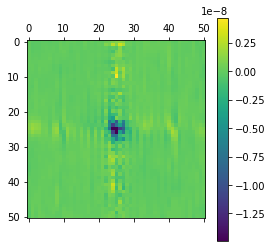

In [34]:
plt.matshow((out[i, 0] - psf[0]).cpu())
plt.colorbar()

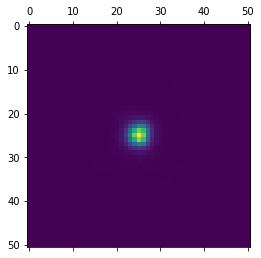

In [75]:
plt.matshow(psf[0].cpu())

In [34]:
torch.nn.functional.conv2d?

In [28]:
psf.shape

torch.Size([1, 51, 51])

In [29]:
gals.shape

torch.Size([2560, 1, 51, 51])

In [18]:
psf.shape

torch.Size([1, 51, 51])

In [6]:
def _sample_uniform(unif_range, shape): 
    # a list of two numbers giving the range
    # from which to sample
    assert unif_range[0] <= unif_range[1]

    return torch.rand(shape, device = device) * (unif_range[1] - unif_range[0]) + unif_range[0]

In [7]:
n_images = 1000

# sample fluxes 
fluxes = _sample_uniform((1000, 10000), n_images)

# sample ellipticity
ells = _sample_uniform((0.1, 1), n_images)

# sample angle
thetas = _sample_uniform((0, np.pi), n_images)

# sample half-light radii
# one for each profile
r_exp = _sample_uniform((1, 5), n_images)
r_dev = _sample_uniform((1, 5), n_images)

p_dev = _sample_uniform((0, 1), n_images)

In [52]:
slen = 50
mgrid = source_simulator_lib._get_mgrid(slen)


galaxy_slen = slen + (slen % 2 == 0)
galaxy_mgrid = source_simulator_lib._get_mgrid(galaxy_slen, normalize = False)

In [53]:
gal = galaxy_simulator_lib.render_centered_galaxy(flux = fluxes, 
                                           theta = thetas, 
                                           ell = ells, 
                                           r_dev = r_dev, 
                                           r_exp = r_exp,
                                           p_dev = p_dev, 
                                           galaxy_mgrid = galaxy_mgrid)

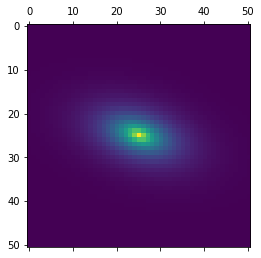

In [54]:
%matplotlib inline
plt.matshow(gal[0, 0].cpu())

In [55]:
from bliss.models.decoder import Tiler

In [84]:
tiler = Tiler(10, 50).to(device)

In [91]:
tiler.cached_grid.shape

torch.Size([50, 50, 2])

In [85]:
locs = _sample_uniform((0, 1), (n_images, 2))

In [86]:
ptiles = tiler.render_one_source(locs, gal)

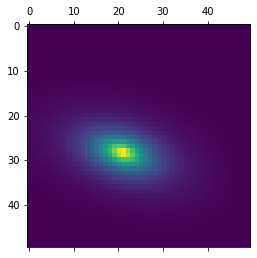

In [87]:
plt.matshow(ptiles[0, 0].cpu())

In [31]:
gals = source_simulator_lib.plot_one_star(slen, locs, gal, cached_grid = mgrid)

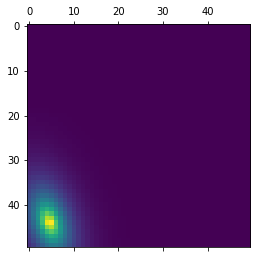

In [32]:
plt.matshow(gals[0, 0].cpu())

# Load PSF

In [26]:
sdss_psf = sdss.SdssPSF(psf_file, [2])

psf = sdss_psf.psf_at_points(0, 0., 0.)

torch.Size([10, 1, 51, 51])

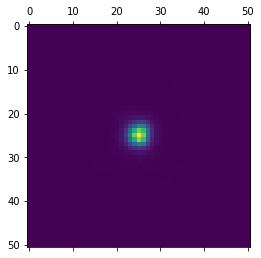

In [13]:
plt.matshow(psf)

# Let us consider a small chuck

In [14]:
clen = 50

x0 = 150
y0 = 200

xlim = (x0, x0 + clen)
ylim = (y0, y0 + clen)
print('coordinates: ', xlim, ylim)

image_chunk = image[0, ylim[0]:ylim[1], xlim[0]:xlim[1]]
background_chunk = background[0, ylim[0]:ylim[1], xlim[0]:xlim[1]]

# restrict to 200x200 chunk 
keep = (px > xlim[0]) & (px < xlim[1]) & (py < ylim[1]) & (py > ylim[0])

print('n sources: ', keep.sum())

coordinates:  (150, 200) (200, 250)
n sources:  1


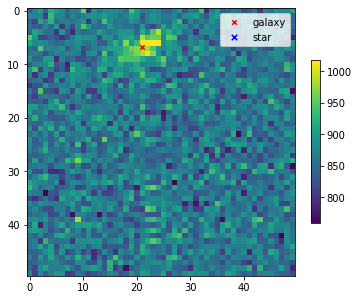

In [15]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))


p_level = 0.1
vmin = np.percentile(image_chunk.flatten(), p_level)
vmax = np.percentile(image_chunk.flatten(), 100-p_level)

# coordinates in the chunk
c_px = px[keep] - xlim[0]
c_py = py[keep] - ylim[0]

c_is_star = is_star[keep]

# and show it with correct centers.
im = ax.imshow(image_chunk, vmin=vmin, vmax=vmax)
ax.scatter(c_px[~c_is_star], c_py[~c_is_star], marker='x', color='r', s=20, label = 'galaxy')
ax.scatter(c_px[c_is_star], c_py[c_is_star], marker='x', color='b', s=30, label = 'star')
fig.colorbar(im, ax=ax, shrink=0.5)
ax.legend()

# Test my simulator

In [16]:
_psf = torch.Tensor([psf]).to(device)
_back = torch.Tensor([background_chunk]).to(device)

star_simulator = source_simulator_lib.StarSimulator(_psf,
                                                    slen = clen, 
                                                    background = _back,
                                                    transpose_psf = False)

In [17]:
fx = (c_px) / (clen - 1)
fy = (c_py) / (clen - 1)

locs = torch.Tensor([fx, fy]).transpose(0, 1).unsqueeze(0).to(device)
fluxes = torch.Tensor([rfluxes[keep]]).unsqueeze(-1).to(device) 

n_stars = torch.Tensor([len(fx)]).type(torch.LongTensor).to(device)

In [18]:
sim_img = star_simulator.draw_image_from_params(locs, fluxes, n_stars)

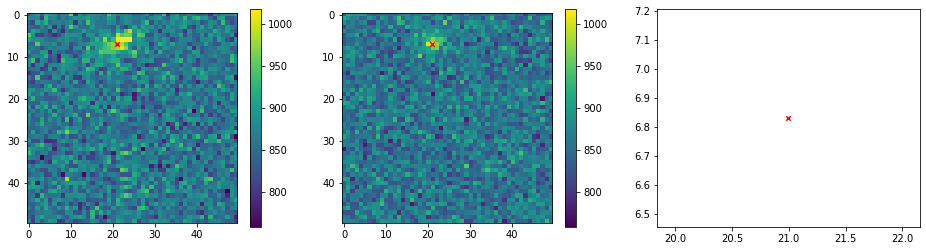

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))

im = ax[0].imshow(image_chunk, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax = ax[0])

im1 = ax[1].imshow(sim_img[0,0].cpu(), vmin=vmin, vmax=vmax)
fig.colorbar(im1, ax = ax[1])

for i in range(3): 
    ax[i].scatter(c_px[~c_is_star], c_py[~c_is_star], marker='x', color='r', s=20, label = 'galaxy')
    ax[i].scatter(c_px[c_is_star], c_py[c_is_star], marker='x', color='b', s=30, label = 'star')


In [21]:
gal_slen = clen + (clen % 2 == 0)
galaxy_mgrid = source_simulator_lib._get_mgrid(gal_slen, normalize = False)

In [36]:
galaxy_mgrid.shape

torch.Size([51, 51, 2])

In [38]:
def render_centered_galaxy(theta, ell, r_dv, r_exp, p_dev, 
                           cached_galaxy_mgrid = None): 
    
    r2_grid = galaxy_simulator_lib._transform_mgrid_to_radius_grid(galaxy_mgrid, 
                                                                   theta = theta,  
                                                                   ell = ell)
    
    # exponential profile
    exp_profile = galaxy_simulator_lib.render_exponential_galaxies(r2_grid, 
                                                                   half_light_radii = r_exp) 
    
    # dev. profile 
    dev_profile = galaxy_simulator_lib.render_exponential_galaxies(r2_grid, 
                                                                   half_light_radii = r_exp)
    
    centered_galaxy = exp_profile * (1 - p_dev) + exp_profile * p_dev
    
    return centered_galaxy.unsqueeze(1)

In [22]:
r2_grid = galaxy_simulator_lib._transform_mgrid_to_radius_grid(galaxy_mgrid, 
                                                               theta = torch.Tensor([0.]), 
                                                               ell = torch.Tensor([1.]))


In [24]:
r_dv = torch.Tensor([fits_file['devrad_r'][:]]).squeeze().to(device)
r_exp = torch.Tensor([fits_file['exprad_r'][:]]).squeeze().to(device)

In [25]:
flux_dv = torch.Tensor(dataset_lib.convert_mag_to_nmgy(fits_file['devmag_r'][:]) * nelec_per_nmgy)
flux_exp = torch.Tensor(dataset_lib.convert_mag_to_nmgy(fits_file['expmag_r'][:]) * nelec_per_nmgy)

In [26]:
flux_exp[keep]

tensor([6564.4282])

In [29]:
flux_dv[keep]

tensor([7880.1729])

In [30]:
fluxes

tensor([[[2531.1077]]], device='cuda:4')

(array([  1.,   1.,   0.,   2.,   7., 114., 767.,   6.,   1.,   2.]),
 array([-3.3681984, -2.8452694, -2.3223405, -1.7994114, -1.2764823,
        -0.7535534, -0.2306244,  0.2923046,  0.8152336,  1.3381627,
         1.8610916], dtype=float32),
 <BarContainer object of 10 artists>)

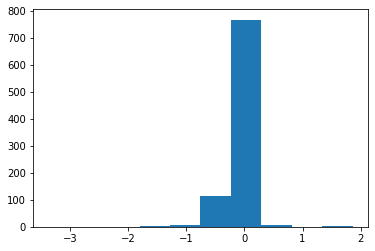

In [34]:
plt.hist(fits_file['devmag_r'][:] - fits_file['expmag_r'][:])

(array([ 15.,  24.,  39.,  65., 185., 327., 183.,  51.,   8.,   4.]),
 array([14.82208 , 16.112719, 17.403358, 18.693998, 19.984638, 21.275278,
        22.565918, 23.856556, 25.147196, 26.437836, 27.728476],
       dtype=float32),
 <BarContainer object of 10 artists>)

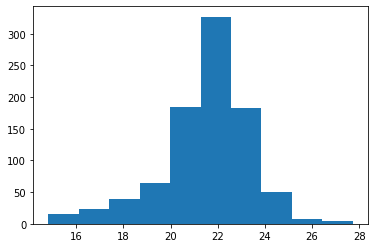

In [152]:
plt.hist(fits_file['psfmag_r'][:])

In [143]:
r_exp[keep]

tensor([1.7641], device='cuda:4')

In [144]:
r2_grid.shape

torch.Size([1, 51, 51])

In [145]:
r

tensor([1.7641], device='cuda:4')

In [148]:
exp_profile = galaxy_simulator_lib.render_exponential_galaxies(r2_grid, 
                                                               half_light_radii = r_exp[keep]) * \
                flux_exp[keep].to(device)

In [153]:
flux_exp[keep]

tensor([6564.4282])

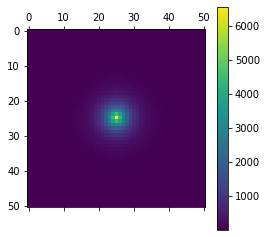

In [154]:
plt.matshow(exp_profile[0].cpu())
plt.colorbar()

In [62]:
x = fits_file['devab_r'][:]

(array([112.,  96.,  96., 108.,  82.,  86.,  95., 103.,  78.,  44.]),
 array([0.05      , 0.14499529, 0.23999058, 0.33498585, 0.42998114,
        0.52497643, 0.6199717 , 0.714967  , 0.8099623 , 0.9049576 ,
        0.99995285], dtype=float32),
 <BarContainer object of 10 artists>)

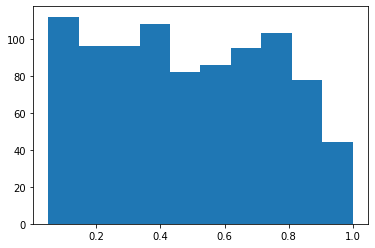

In [63]:
plt.hist(x[x > -1000])